## Load required modules

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
TORCH_MAX = torch.finfo(torch.float64).max

## Define the dataloaders from the csv files

Note that the data input is standardized.

In [2]:
class ContinuationData(torch.utils.data.Dataset):
    def __init__(self, path, noise=0.0, beta=20.0, rescaled=True, standardize=True):
        self.noise = noise
        self.beta = beta
        self.rescaled = rescaled
        self.standardize = standardize

        self.x_data = np.loadtxt(open(path+f"Pi_beta_{beta}.csv", "rb"), delimiter=",")
        self.avg = self.x_data.mean(axis=-2)
        self.std = self.x_data.std(axis=-2)

        self.y_data = np.loadtxt(open(path+"SigmaRe.csv", "rb"), delimiter=",")
        self.y_data_rescaled = np.loadtxt(open(path+"SigmaRe_scaled_4.0.csv", "rb"), delimiter=",")

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = self.x_data[index]
        x += np.random.normal(0,1, size=x.shape)*self.noise
        if self.standardize:
            x = (x - self.avg)/self.std

        if self.rescaled:
            y = self.y_data_rescaled[index]
        else: 
            y = self.y_data[index]
        return x, y

print("loading data...")
train_set = ContinuationData("data/B1/train/", beta=20.0)
valid_set = ContinuationData("data/B1/valid/", beta=20.0)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=523, 
    shuffle=True, 
    drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, 
    batch_size=523, 
    shuffle=False, 
    drop_last=True,
)
print(" done")

loading data...
 done


## Define the Model and initialized weights

In [3]:
class MLP(nn.Module):
    def __init__(self, layers=[128, 952, 1343, 1673, 1722, 512]):
        super(MLP, self).__init__()
        self.epoch = 0
        
        self.layers = nn.ModuleList()
        sizeA = layers[0]
        for sizeB in layers[1:]:
            self.layers.append(nn.Linear(sizeA, sizeB))
            self.layers.append(nn.ReLU())
            sizeA = sizeB

        self.layers.append(nn.Linear(sizeA, layers[-1]))
        self.layers.append(nn.Softmax(dim=-1))
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


def initialize_weights(module, gain=1):
    if type(module) == nn.Linear:
        torch.nn.init.xavier_uniform_(module.weight, gain=gain)
        torch.nn.init.zeros_(module.bias)

model = MLP().to(device)
model.apply(initialize_weights)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=952, bias=True)
    (1): ReLU()
    (2): Linear(in_features=952, out_features=1343, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1343, out_features=1673, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1673, out_features=1722, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1722, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Softmax(dim=-1)
  )
)

## Define the loss function, optimizer, and learning rate scheduler

In [4]:
loss_function = nn.L1Loss()  
mse_function = nn.MSELoss()

lr = 8e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.216, 
    patience=5,
    verbose=True,
    min_lr=1e-10
)

## Training and validation loop
Use a learning rate warmup, early stopping and plot a spectrum each epoch 

 epoch 1
   train loss: 0.000434999, mse: 0.000292029
   valid loss: 0.000433393, mse:0.000027839


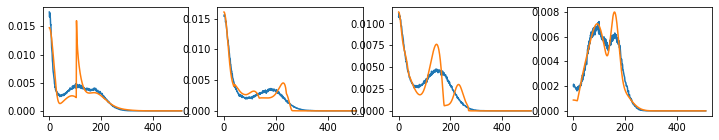

 epoch 2
   train loss: 0.000433609, mse: 0.000288823
   valid loss: 0.000426321, mse:0.000027204


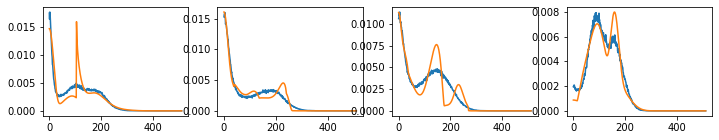

 epoch 3
   train loss: 0.000426955, mse: 0.000283306
   valid loss: 0.000421372, mse:0.000026894


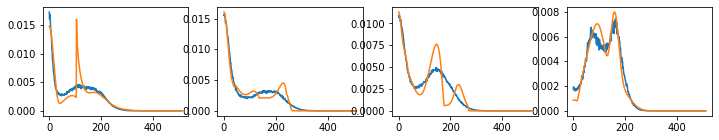

 epoch 4
   train loss: 0.000421023, mse: 0.000278599
   valid loss: 0.000412690, mse:0.000026266


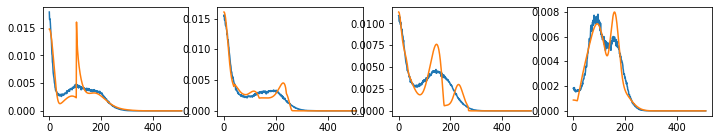

 epoch 5
   train loss: 0.000414461, mse: 0.000274243
   valid loss: 0.000423775, mse:0.000025916


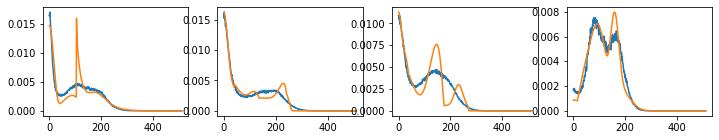

 epoch 6
   train loss: 0.000407880, mse: 0.000268954
   valid loss: 0.000412355, mse:0.000025892


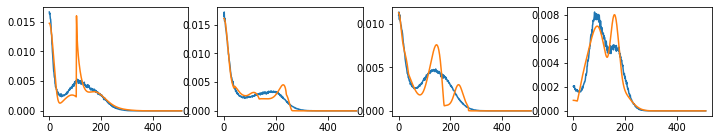

 epoch 7
   train loss: 0.000402972, mse: 0.000264990
   valid loss: 0.000394152, mse:0.000024727


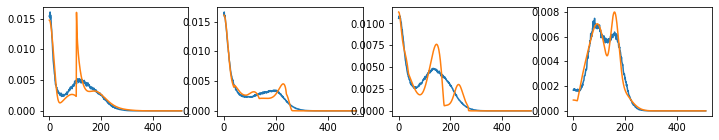

 epoch 8
   train loss: 0.000395984, mse: 0.000259743
   valid loss: 0.000387674, mse:0.000024363


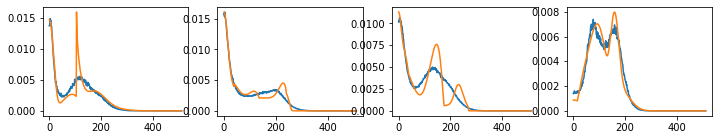

 epoch 9


In [ ]:
n_epochs = 200
early_stop_count = 40
best_valid_loss = TORCH_MAX
for epoch in range(1, n_epochs+1):
    print(f' epoch {epoch}')
    avg_train_loss = 0
    avg_train_mse = 0

    model.train()
    for batch_number, (inputs, targets) in enumerate(train_loader):
        
        # learning rate warmup
        if epoch == 1: 
            tmp_lr = (batch_number+1)*lr/len(train_loader)
            for g in optimizer.param_groups:
                g['lr'] = tmp_lr

        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        mse = mse_function(outputs, targets)
        avg_train_mse += mse.item()
        avg_train_loss += loss.item()
    
    avg_train_loss = avg_train_loss/len(train_loader)
    print(f'   train loss: {avg_train_loss:.9f}, mse: {avg_train_mse:.9f}')

    model.eval()
    avg_valid_loss = 0
    avg_valid_mse = 0
    for batch_number, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        mse = mse_function(outputs, targets)
        avg_valid_loss += loss.item()
        avg_valid_mse += mse.item()

    avg_valid_loss = avg_valid_loss/len(valid_loader)
    print(f'   valid loss: {avg_valid_loss:.9f}, mse:{avg_valid_mse:.9f}')
    
    # plot a few validation spectra
    offset = 10
    n_plots = 4
    _, ax = plt.subplots(1,n_plots, figsize=(12,2))
    for i in range(n_plots):
        ax[i].plot(outputs[i+offset].detach().numpy())
        ax[i].plot(targets[i+offset].detach().numpy())
    plt.pause(0.001)
    
    scheduler.step(avg_train_loss)
    early_stop_count -= 1
    if avg_valid_loss < best_valid_loss:
        early_stop_count = 40
        best_valid_loss = avg_valid_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        
    if early_stop_count == 0:
        print('early stopping limit reached!!')
        print(f'best epoch was {best_epoch}')
        break

## Saving the best model

In [ ]:
torch.save(best_model.state_dict(), "best_model.pt")

## Loading the model

In [ ]:
loaded_model = MLP().to(device)
loaded_model.load_state_dict(torch.load("best_model.pt", map_location=device))

outputs = loaded_model(inputs)
plt.plot(outputs[0].detach().numpy())
plt.plot(targets[0].detach().numpy())
plt.title(f"o:{outputs[0].sum().detach().numpy()}, t:{targets[0].sum().detach().numpy()}")
plt.show()